In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn
xarray = mre_pinn.utils.as_xarray

torch.cuda.is_available()

Using backend: pytorch

Loading /ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks/../mre_pinn/__init__.py


True

In [4]:
%autoreload

# load the FEM box data set
data = mre_pinn.data.load_bioqic_fem_box_data('../data/BIOQIC')

# select data subset
data, ndim = mre_pinn.data.select_data_subset(
    data,
    downsample=False,
    frequency=None,
    x_slice=None,
    y_slice=75,
    z_slice=0
)

u  = data['u']
mu = data['mu']

data

Multi frequency
1D


<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, component: 1)
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
    y          float64 0.075
    z          float64 0.0
  * component  (component) <U1 'z'
Data variables:
    u          (frequency, x, component) complex128 (-1.3737389906009136e-05+...
    mu         (frequency, x) complex128 (3000+314.1592653589793j) ... (3000+...

In [5]:
%autoreload

# direct Helmholtz inversion via discrete laplacian

Lu = mre_pinn.discrete.laplacian(u, resolution=1e-3, dim=1)
Mu = mre_pinn.discrete.helmholtz_inversion(u, Lu, u.frequency)

data['Lu'] = Lu
data['Mu'] = Mu

<IPython.core.display.Javascript object>


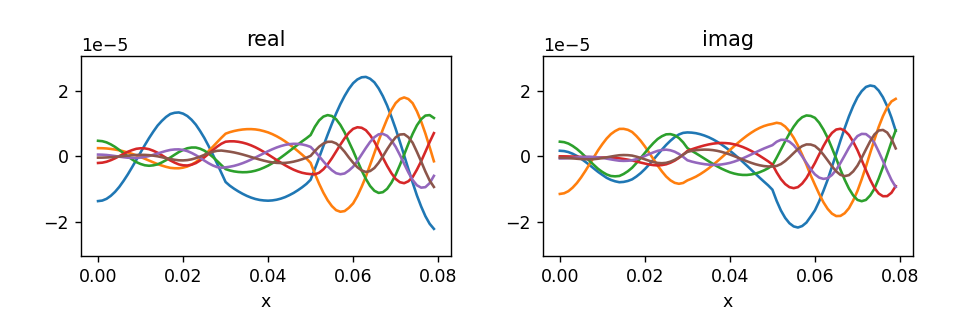

interactive(children=(IntSlider(value=0, description='component', max=0), Output()), _dom_classes=('widget-int…

In [6]:
%autoreload

# configure color maps
pct = 95 if ndim > 1 else 100

w_map = mre_pinn.visual.wave_color_map()
w_max = np.percentile(np.abs(u), pct) * 1.1
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

L_max = np.percentile(np.abs(Lu), pct) * 1.1
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = np.percentile(np.abs(mu), pct) * 1.1
elast_kws = dict(cmap=e_map, vmin=-e_max, vmax=e_max)

# display true wave field and elastogram
viewer = mre_pinn.visual.XArrayViewer(u, y=None, hue='frequency', col='part', **wave_kws)

In [7]:
%autoreload

# create point set boundary condition

batch_size = 80 # training data points
u_bc = mre_pinn.data.XArrayBC(u, batch_size=batch_size)

#bc.points = bc.points.astype(np.complex128)

x = u_bc.points
u_true = u_bc.values
print('x     ', type(x), tuple(x.shape), x.dtype)
print('u_true', type(u_true), tuple(u_true.shape), u_true.dtype)

x      <class 'numpy.ndarray'> (480, 2) float32
u_true <class 'torch.Tensor'> (480, 1) torch.complex64


In [8]:
%autoreload

# set up PDE with geometry and boundary condition
wave_eq = mre_pinn.pde.WaveEquation(detach=True)

# need to add eps to singleton dimensions to avoid zero volume
eps = np.where(np.array(u.shape[:-1]) > 1, 0, 1e-5)

geometry = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + eps)
pde = deepxde.data.PDE(
    geometry, wave_eq, u_bc,
    num_domain=0,
    anchors=u_bc.points,
    train_distribution='Sobol'
)

train_x = np.array(pde.train_x)
train_x.shape

(560, 2)

In [101]:
%autoreload

# define model architecture

x = u_bc.points
u_true = u_bc.values
mu_true = mu.to_numpy().reshape(-1, 1)

net = mre_pinn.model.MRE_PINN(
    input=x,
    outputs=[u_true, mu_true],
    omega0=16,
    n_layers=3,
    n_hidden=1024,
    activ_fn='s',
    parallel=True,
    dense=True,
    dtype=torch.float32
)
u_bc.points = u_bc.points.astype(np.float32)

net

MRE_PINN(
  (0): InputScaler()
  (1): Parallel(
    (0): Feedforward(
      (linear0_sin): Linear(in_features=2, out_features=1024, bias=True)
      (linear1_sin): Linear(in_features=1026, out_features=1024, bias=True)
      (linear2): Linear(in_features=2050, out_features=2, bias=True)
    )
    (1): Feedforward(
      (linear0_sin): Linear(in_features=2, out_features=1024, bias=True)
      (linear1_sin): Linear(in_features=1026, out_features=1024, bias=True)
      (linear2): Linear(in_features=2050, out_features=2, bias=True)
    )
  )
  (2): RealToComplex()
  (3): OutputScaler()
)

x [[7.50e+01 3.95e-02]] [[25.      0.0395]]
u [[3.60590586e-07-5.20129502e-07j]] [[9.83510844e-06]]
mu [[4688.4460942+471.23889804j]] [[2918.81510864]]


<IPython.core.display.Javascript object>


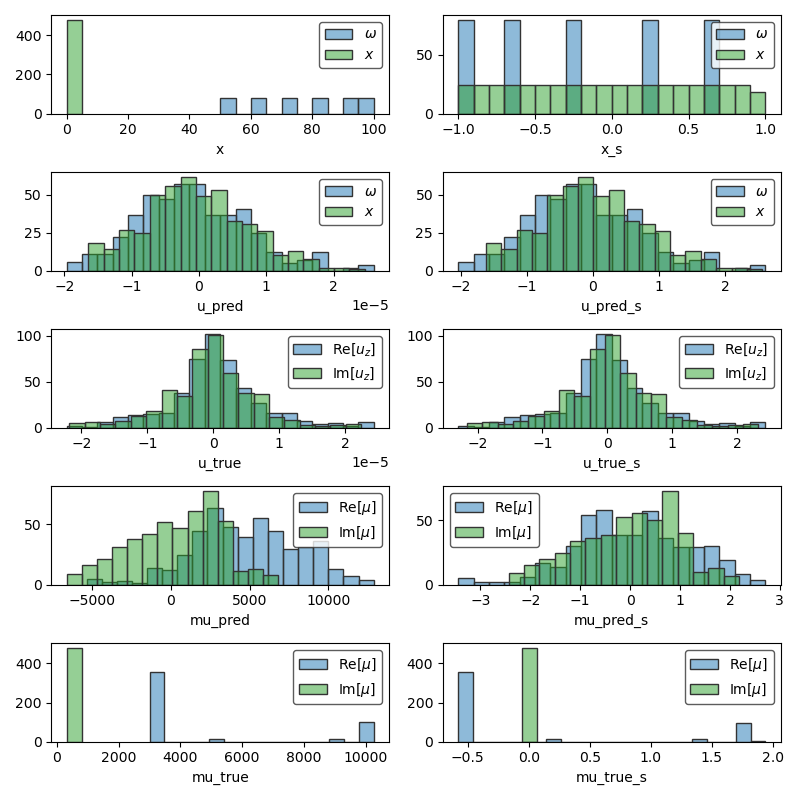

In [102]:
# descriptive statistics

kws = dict(axis=0, keepdims=True)

# standardize input to [-1, 1]
x = u_bc.points
x_loc = x.mean(**kws)
x_scale = (x.max(**kws) - x.min(**kws)) / 2
print('x', x_loc, x_scale)

# avoid division by zero
x_scale[x_scale == 0] = 1
x_s = (x - x_loc) / x_scale

# test forward pass
u_pred, mu_pred = torch.split(net(torch.as_tensor(x)), net.n_outputs, dim=1)
u_pred = u_pred.detach().cpu().numpy()
mu_pred = mu_pred.detach().cpu().numpy()

# normalize outputs via mean and std
u_true = u.to_numpy().reshape(-1, u.shape[-1])
u_loc = u_true.mean(**kws)
u_scale = u_true.std(**kws)
print('u', u_loc, u_scale)

u_true_s = (u_true - u_loc) / u_scale
u_pred_s = (u_pred - u_loc) / u_scale

mu_true = mu.to_numpy().reshape(-1, 1)
mu_loc = mu_true.mean(**kws)
mu_scale = mu_true.std(**kws)
print('mu', mu_loc, mu_scale)

mu_true_s = (mu_true - mu_loc) / mu_scale
mu_pred_s = (mu_pred - mu_loc) / mu_scale

# display input and output distributions

def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def plot_hist(ax, a, xlabel, hue=None):
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a)
    data = pd.DataFrame({})
    bin_width = (a.max() - a.min()) / 20
    for a, hue in zip(a.T, hue):
        bins = np.arange(a.min(), a.max() + bin_width, bin_width)
        color = next(ax._get_lines.prop_cycler)["color"]
        ax.hist(a, bins=bins, label=hue, edgecolor='0.2', fc=color + '80')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=True, edgecolor='0.2')

fig, axes = plt.subplots(5, 2, figsize=(8, 8))

x_hues = ['$\omega$', '$x$', '$y$', '$z$']
plot_hist(axes[0,0], x,   hue=x_hues, xlabel='x')
plot_hist(axes[0,1], x_s, hue=x_hues, xlabel='x_s')

plot_hist(axes[1,0], u_pred,   hue=x_hues, xlabel='u_pred')
plot_hist(axes[1,1], u_pred_s, hue=x_hues, xlabel='u_pred_s')

plot_hist(axes[2,0], u_true,   hue=['Re[$u_z$]', 'Im[$u_z$]'], xlabel='u_true')
plot_hist(axes[2,1], u_true_s, hue=['Re[$u_z$]', 'Im[$u_z$]'], xlabel='u_true_s')

plot_hist(axes[3,0], mu_pred,   hue=['Re[$\mu$]', 'Im[$\mu$]'], xlabel='mu_pred')
plot_hist(axes[3,1], mu_pred_s, hue=['Re[$\mu$]', 'Im[$\mu$]'], xlabel='mu_pred_s')

plot_hist(axes[4,0], mu_true,   hue=['Re[$\mu$]', 'Im[$\mu$]'], xlabel='mu_true')
plot_hist(axes[4,1], mu_true_s, hue=['Re[$\mu$]', 'Im[$\mu$]'], xlabel='mu_true_s')

fig.tight_layout()

In [104]:
%autoreload

pde.pde = mre_pinn.pde.WaveEquation(detach=True, homogeneous=True, incompressible=True)

# create normalized loss functions
u_norm = torch.norm(u_bc.values, dim=-1).mean().detach()
print(u_norm)

def normalized_L2_loss(norm):
    def loss_fn(y_true, y_pred):
        return torch.mean(
            (torch.norm(y_true - y_pred, dim=-1) / norm)
        )
    return loss_fn

loss = normalized_L2_loss(u_norm)

def predicted_L2_norm(idx, n):
    def norm(y_true, y_pred):
        return np.mean(
            np.linalg.norm(y_pred[:,idx:idx+n], axis=-1)
        )
    return norm

metrics = [
    predicted_L2_norm(net.idxs[i], n) for i, n in enumerate(net.n_outputs)
]

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=5e-5,
    loss_weights=[1e-7, 1],
    loss=loss,
    metrics=metrics,
)
batch_predict = mre_pinn.utils.minibatch(model.predict, batch_size)
batch_size

tensor(7.8095e-06)
Compiling model...
'compile' took 0.000136 s



80

Training model...



<IPython.core.display.Javascript object>


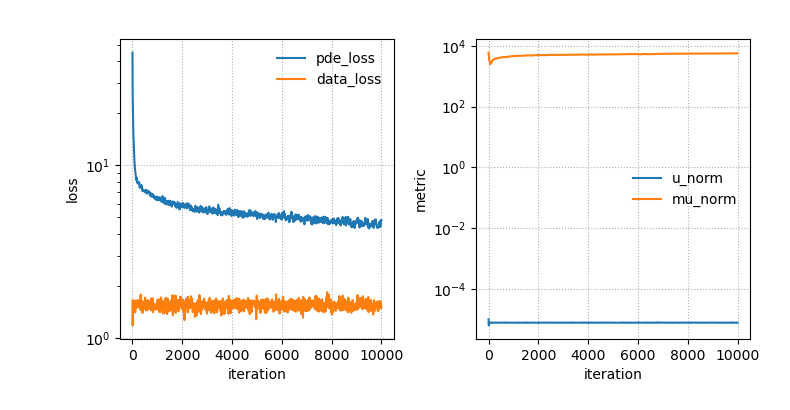

<IPython.core.display.Javascript object>


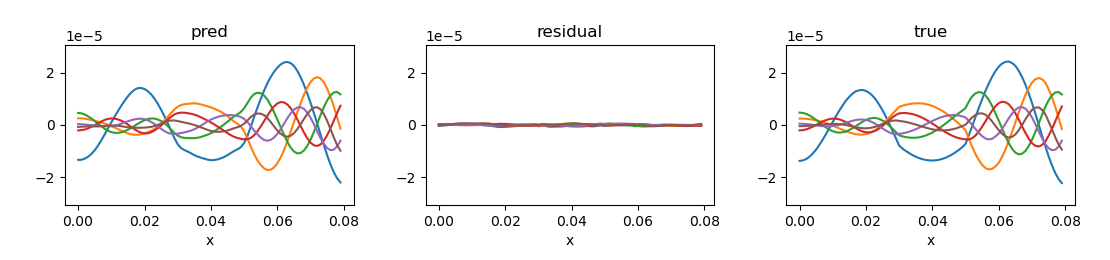

interactive(children=(IntSlider(value=0, description='part', max=1), IntSlider(value=0, description='component…

<IPython.core.display.Javascript object>


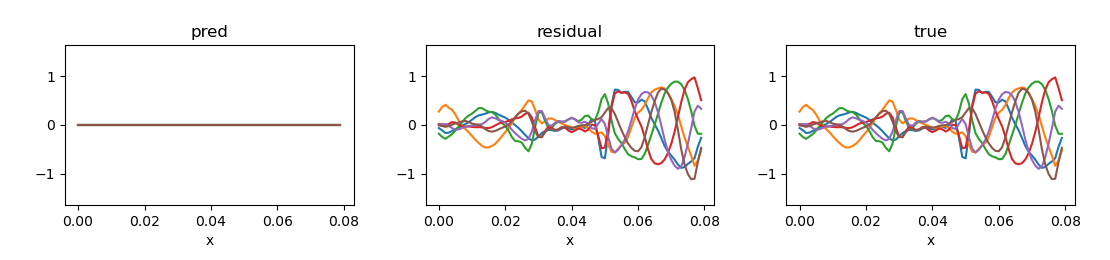

interactive(children=(IntSlider(value=0, description='part', max=1), IntSlider(value=0, description='component…

<IPython.core.display.Javascript object>


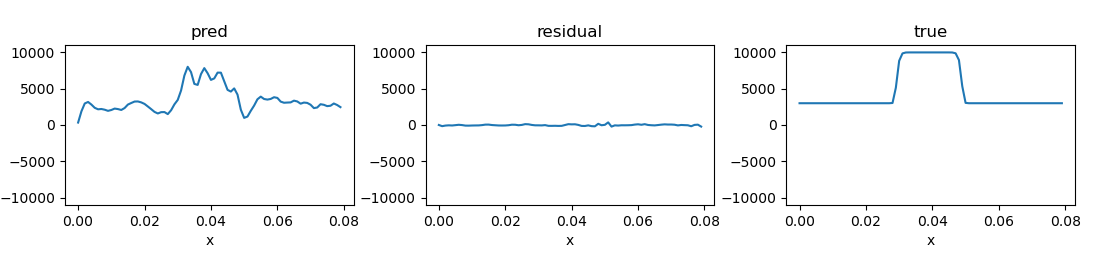

interactive(children=(IntSlider(value=0, description='part', max=1), Output()), _dom_classes=('widget-interact…


Best model at step 9510:
  train loss: 4.35e+00
  test loss: 5.90e+00
  test metric: [7.84e-06, 5.62e+03]

'train' took 285.457313 s



In [105]:
%autoreload

deepxde.display.training_display = mre_pinn.visual.TrainingPlot(
    losses=['pde_loss', 'data_loss'],
    metrics=['u_norm', 'mu_norm']
)

def laplacian_u(x, outputs):
    u = outputs[:,net.idxs[0]:net.idxs[1]]
    lu = mre_pinn.pde.laplacian(u, x, dim=1)
    deepxde.gradients.clear()
    return lu

class PDEPointResampler(deepxde.callbacks.Callback):

    def on_batch_end(self):
        self.model.data.train_x_all = None
        self.model.data.train_x_bc = None
        self.model.data.resample_train_points()


class OutputViewer(deepxde.callbacks.Callback):
    
    def __init__(self, update_every, spectrum=False, residual=False):
        self.update_every = update_every
        self.spectrum = spectrum
        self.residual = residual
        super().__init__()
        
    def get_outputs(self):
        
        x = self.model.data.bcs[0].points
        x = torch.as_tensor(x).requires_grad_(True)
        outputs = self.model.net(x)
        u_pred, mu_pred = torch.split(outputs, self.model.net.n_outputs, dim=1)
        
        pde = model.data.pde(x, outputs)
        lu_pred = mre_pinn.pde.laplacian(u_pred, x)
        deepxde.gradients.clear()
        
        u, mu = data['u'], data['mu']
        u_pred  = u_pred.detach().cpu().numpy().reshape(u.shape)
        lu_pred = lu_pred.detach().cpu().numpy().reshape(u.shape)
        Lu_pred = mre_pinn.discrete.laplacian(u_pred, resolution=1e-3, dim=1).reshape(u.shape)
        mu_pred = mu_pred.detach().cpu().numpy().reshape(mu.shape)
        pde = pde.detach().cpu().numpy().reshape(mu.shape)
        
        u_pred  = mre_pinn.utils.as_xarray(u_pred,  like=u)
        lu_pred = mre_pinn.utils.as_xarray(lu_pred, like=u)
        Lu_pred = mre_pinn.utils.as_xarray(Lu_pred, like=u)
        mu_pred = mre_pinn.utils.as_xarray(mu_pred, like=mu)
        pde = mre_pinn.utils.as_xarray(pde, like=mu)

        if self.spectrum: # get spatial frequency spectrum
            u = mre_pinn.discrete.sfft(u)
            mu = mre_pinn.discrete.sfft(mu)
            u_pred = mre_pinn.discrete.sfft(u_pred)
            mu_pred = mre_pinn.discrete.sfft(mu_pred)
            lu_pred = mre_pinn.discrete.sfft(lu_pred)
            Lu_pred = mre_pinn.discrete.sfft(Lu_pred)
            pde = mre_pinn.discrete.sfft(pde)

        if self.residual: # get residuals
            dim = xr.DataArray(['pred', 'residual', 'true'], dims=['residual'])
            u_pred  = xr.concat([u_pred,  u - u_pred, u], dim=dim)
            lu_pred = xr.concat([lu_pred, Lu_pred - lu_pred, Lu_pred], dim=dim)
            mu_pred = xr.concat([mu_pred, pde, mu], dim=dim)

        return u_pred, lu_pred, mu_pred.mean('frequency')

    def on_train_begin(self):
        u_pred, lu_pred, mu_pred = self.get_outputs()
        self.u_viewer  = mre_pinn.visual.XArrayViewer(u_pred,  y=None, hue='frequency', col='residual', **wave_kws)
        self.lu_viewer = mre_pinn.visual.XArrayViewer(lu_pred, y=None, hue='frequency', col='residual', **laplace_kws)
        self.mu_viewer = mre_pinn.visual.XArrayViewer(mu_pred, y=None, hue=None, col='residual', **elast_kws)

    def on_batch_end(self):
        if self.model.train_state.step % self.update_every != 0:
            return
        u_pred, lu_pred, mu_pred = self.get_outputs()
        self.u_viewer.update_array(u_pred)
        self.lu_viewer.update_array(lu_pred)
        self.mu_viewer.update_array(mu_pred)

callbacks = [PDEPointResampler(), OutputViewer(update_every=10, residual=True)]
try:
    model.train(10000, display_every=10, callbacks=callbacks)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
# model predictions
x = u_bc.points
outputs = batch_predict(x)
u_pred, mu_pred = np.split(outputs, net.n_outputs[1:], axis=1)
u_pred = u_pred.reshape(u.shape)
mu_pred = mu_pred.reshape(mu.shape)

lu_pred = batch_predict(x, operator=laplacian_u)
lu_pred = lu_pred.reshape(u.shape)

u_pred  = mre_pinn.utils.as_xarray(u_pred,  like=u)
lu_pred = mre_pinn.utils.as_xarray(lu_pred, like=u)
mu_pred = mre_pinn.utils.as_xarray(mu_pred, like=mu)

In [ ]:
%autoreload

# display wave fields
mre_pinn.visual.XArrayViewer(
    xr.concat([u_pred, u - u_pred, u], dim='which'), y=y, hue='which', **wave_kws
)

In [ ]:
# display wave field Laplacians

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=1e-3, dim=1)
Lu_pred = mre_pinn.discrete.laplacian(u_pred, resolution=1e-3, dim=1)

mre_pinn.visual.XArrayViewer(
    xr.concat([lu_pred, lu_pred - Lu, Lu], dim='which'), y=y, hue='which', **laplace_kws
)

In [ ]:
%autoreload

# display reconstructed elastograms

omega = u.frequency.to_numpy().reshape(-1, 1, 1)
mu_data = mre_pinn.discrete.helmholtz_inversion(u, Lu_true, omega) #.mean(axis=0)
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_pred, Lu_pred, omega) #.mean(axis=0)
mu_u_lu = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_pred, omega) #.mean(axis=0)
#mu_pred = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_model, omega)

mre_pinn.visual.XArrayViewer(
    xr.concat([mu_pred, mu_pred - mu, mu], dim='which'), y=y, hue='which', **elast_kws
)

In [ ]:
# try out complex initialization schemes

def runiform(n, scale=1):
    return (2 * torch.rand(n) - 1) * scale

def cuniform(n, scale=1):
    radius = torch.rand(n) * scale 
    angle  = torch.rand(n) * 2 * np.pi
    return radius * torch.exp(1j * angle)

n = 10000
d = 2
layers = [16, 16, 16, 16]
sin = torch.sin
cis = lambda x: torch.cos(x) + 1j * torch.sin(x)
gas = lambda x: torch.exp(-x**2)
wav = lambda x: cis(x) * gas(x)

fig, axes = plt.subplots(len(layers) + 2, 2, figsize=(6, 1.5*(len(layers) + 2)), squeeze=False)

def plot_hist(ax, a):
    a = a.detach().cpu().numpy().flatten()
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a, interleave=False)
    sns.histplot(a, bins=20, ax=ax, legend=True)

a = runiform((n, d))
b = runiform((n, d)) + 0j
plot_hist(axes[0,0], a)
plot_hist(axes[0,1], b)

for i, w in enumerate(layers):
    if i == 0:
        a_scale = 32 / d
        b_scale = 32 / d
    else:
        a_scale = np.sqrt(6 / d)
        b_scale = np.sqrt(6 / d)
    a = sin(a @ runiform((d, w), a_scale))
    b = cis(b @ cuniform((d, w), b_scale))
    plot_hist(axes[i+1,0], a)
    plot_hist(axes[i+1,1], b)
    d = w

a = a @ runiform((d, 1))
b = b @ cuniform((d, 1))
plot_hist(axes[-1,0], a)
plot_hist(axes[-1,1], b)
fig.tight_layout()